In [134]:
# %matplotlib inline

In [135]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle

In [136]:
pkl_filename = "pre_processing/times_scaler.pkl"
with open(pkl_filename, 'rb') as file:
    times_scaler = pickle.load(file)

In [137]:
times_scaler

MinMaxScaler(feature_range=(-1, 1))

In [138]:
times = np.load("training_data/times.npy")

In [139]:
times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]

In [140]:
times

array([-499.53870533, -499.03870533, -498.53870533, ...,   48.46129467,
         48.96129467,   49.46129467])

In [141]:
times_scaled

array([-1.        , -0.99817851, -0.99635701, ...,  0.99635701,
        0.99817851,  1.        ])

In [142]:
times.shape

(1099,)

In [143]:
times_scaled.shape

(1099,)

In [144]:
amps = np.load("training_data/amplitude.npy")
amp_processing_params = np.load("pre_processing/amp_preprocessing_params.npz")

# amps = np.load("training_data/phase.npy")
# amp_processing_params = np.load("pre_processing/phase_preprocessing_params.npz")

In [145]:
amps.shape

(10, 1099)

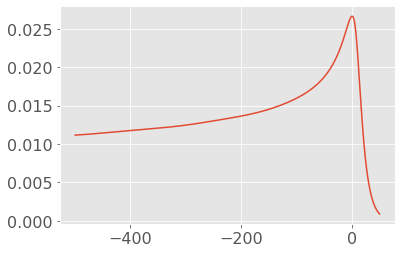

In [146]:
plt.figure()
plt.plot(times, amps[0])

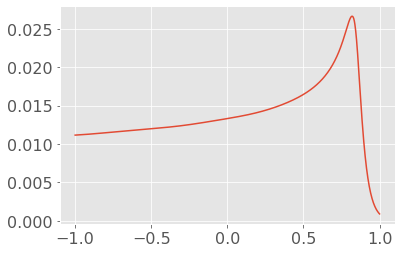

In [147]:
plt.figure()
plt.plot(times_scaled, amps[0])

In [148]:
list(amp_processing_params)

['mean', 'max']

In [149]:
amp_processing_params['mean']

array([[0.01083173, 0.01083493, 0.01083816, ..., 0.00091624, 0.00087329,
        0.00083236]])

In [150]:
amp_processing_params['mean'].shape

(1, 1099)

In [151]:
amp_processing_params['max']

array(0.00453117)

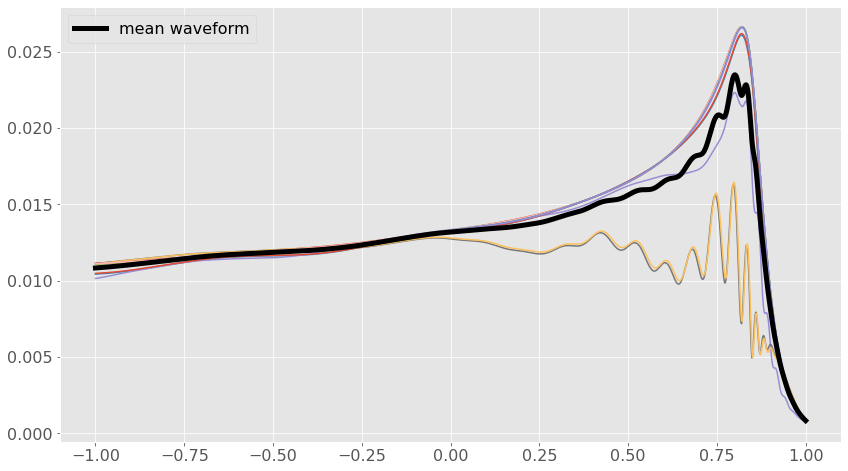

In [152]:
plt.figure(figsize=(14, 8))
for y in amps:
    plt.plot(times_scaled, y)
    
plt.plot(times_scaled, amp_processing_params['mean'][0], label='mean waveform', lw=5, c='k')
plt.legend()

In [153]:
import compute_preprocessing

In [154]:
amps_scaled = compute_preprocessing.apply_pre_process_forward(amps, amp_processing_params['mean'], amp_processing_params['max'])

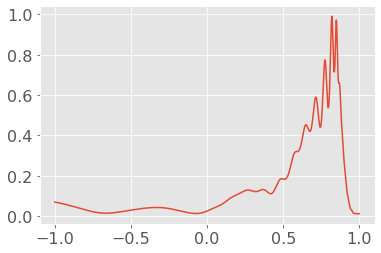

In [155]:
plt.figure()
plt.plot(times_scaled, amps_scaled[0])

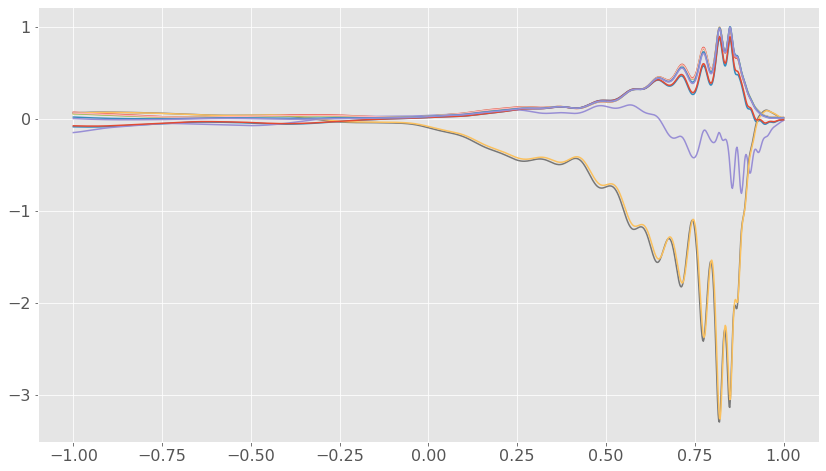

In [156]:
plt.figure(figsize=(14, 8))
for y in amps_scaled:
    plt.plot(times_scaled, y)
#     plt.plot(times, y)
# plt.xlim(-100, 100)

In [157]:
amps_scaled_reverse = compute_preprocessing.apply_pre_process_reverse(amps_scaled, amp_processing_params['mean'], amp_processing_params['max'])

In [158]:
np.testing.assert_array_almost_equal(amps, amps_scaled_reverse)

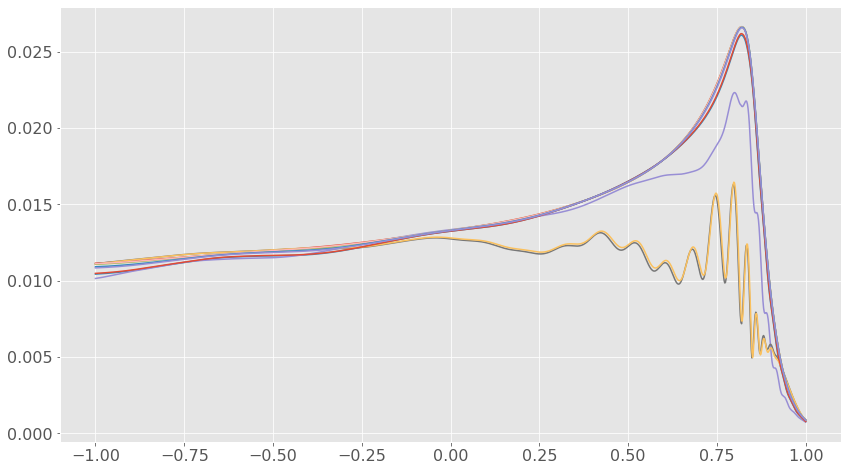

In [159]:
plt.figure(figsize=(14, 8))
for y in amps_scaled_reverse:
    plt.plot(times_scaled, y)

# setting up the domain

In [160]:
coords = np.load("training_data/coords.npy")

In [161]:
times.shape

(1099,)

In [162]:
coords.shape

(3, 10)

In [163]:
amps.shape

(10, 1099)

In [164]:
np.outer(coords, times).shape

(30, 1099)

In [165]:
(times[:, np.newaxis]*coords[0]).shape

(1099, 10)

In [166]:
1099 * 3

3297

In [167]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [168]:
X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

In [169]:
y = amps.ravel()
print(y.shape)

# X = []


# # for b,c,d in coords.T:

# bb = coords[0]
# cc = coords[1]
# dd = coords[2]

# for b,c,d in zip(bb,cc,dd):
#     for a in times_scaled:
# #         print(a,b,c,d)
#         X.append([a,b,c,d])
# X = np.asarray(X)

(10990,)


In [170]:
coords[0]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [171]:
coords[1]

array([0.04827217, 0.35931256, 0.63776295, 0.94763127, 0.9400828 ,
       0.09568319, 0.07467322, 0.34044798, 0.17788329, 0.20692044])

In [172]:
coords[2]*180/np.pi

array([89.99448088, 89.99448088, 89.99448088, 89.99448088, 89.99448088,
       89.99448088, 89.99448088, 89.99448088, 89.99448088, 89.99448088])

In [173]:
X.shape

(10990, 4)

In [174]:
X[2]

array([-0.99635701,  3.        ,  0.04827217,  1.5707    ])

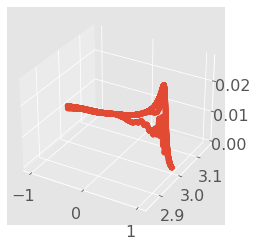

In [175]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], y)

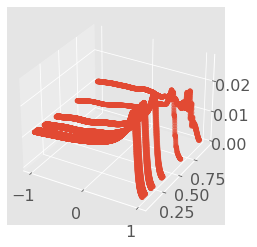

In [176]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,2], y)

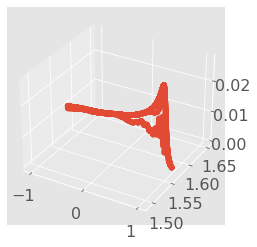

In [177]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,3], y)

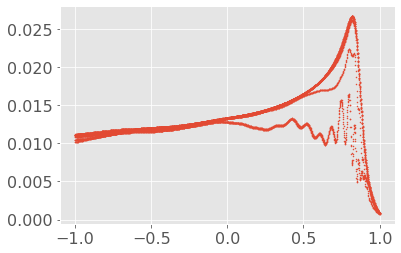

In [178]:
plt.figure()
plt.scatter(X[:,0], y, s=1)

# load model

In [179]:
import tensorflow as tf

In [180]:
import pugna.layers
import pugna.activations

In [181]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [182]:
model = tf.keras.models.load_model("fit/model.h5",
                                   custom_objects={'Mscale': pugna.layers.Mscale,
                                                  'Activation':tf.keras.layers.Activation,
                                                  'name':pugna.activations.s2relu})
# model = tf.keras.models.load_model("fit/model.h5")

In [183]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale_6 (Mscale)            (None, 300)               1500      
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               90300     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 182,401
Trainable params: 182,401
Non-trainable params: 0
_________________________________________________________________


In [203]:
# model.layers[0].K

In [184]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [185]:
coords.shape

(3, 10)

In [186]:
coords[1]

array([0.04827217, 0.35931256, 0.63776295, 0.94763127, 0.9400828 ,
       0.09568319, 0.07467322, 0.34044798, 0.17788329, 0.20692044])

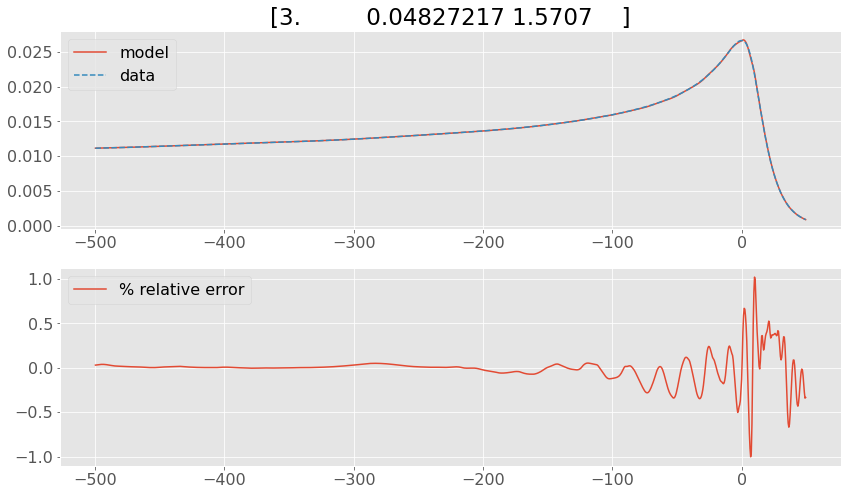

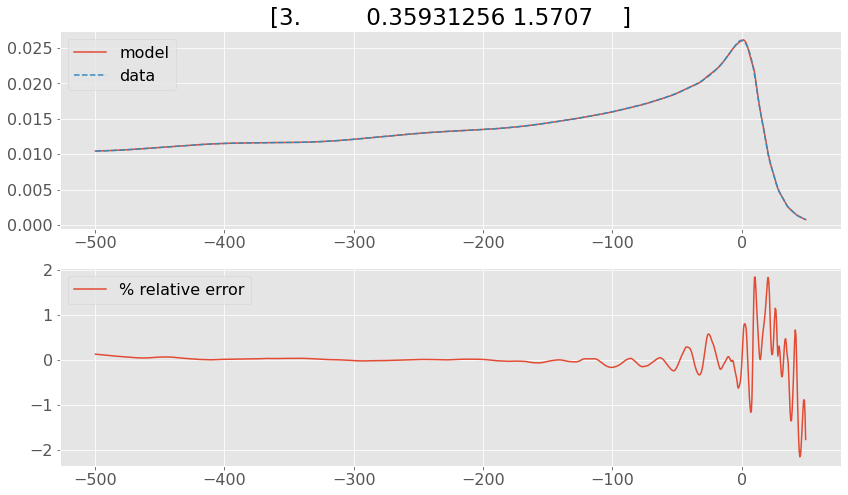

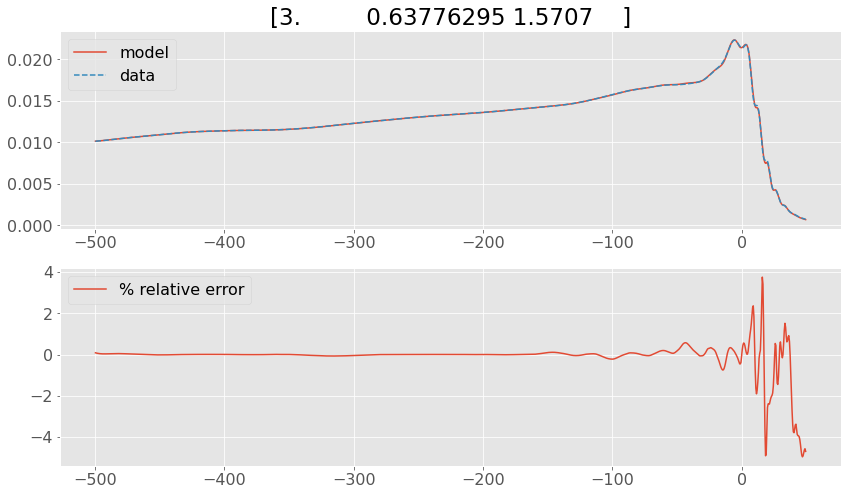

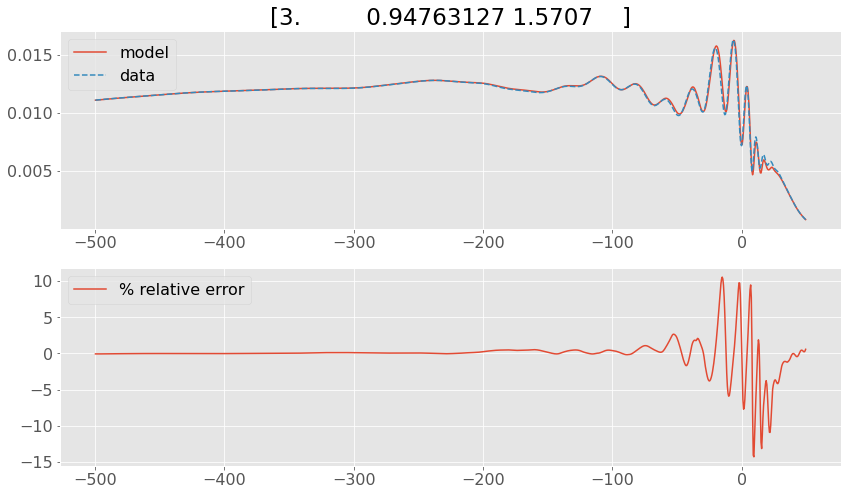

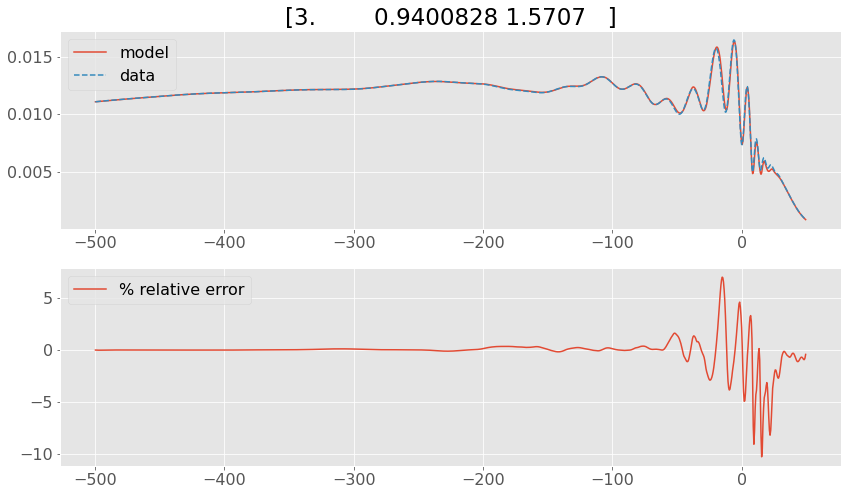

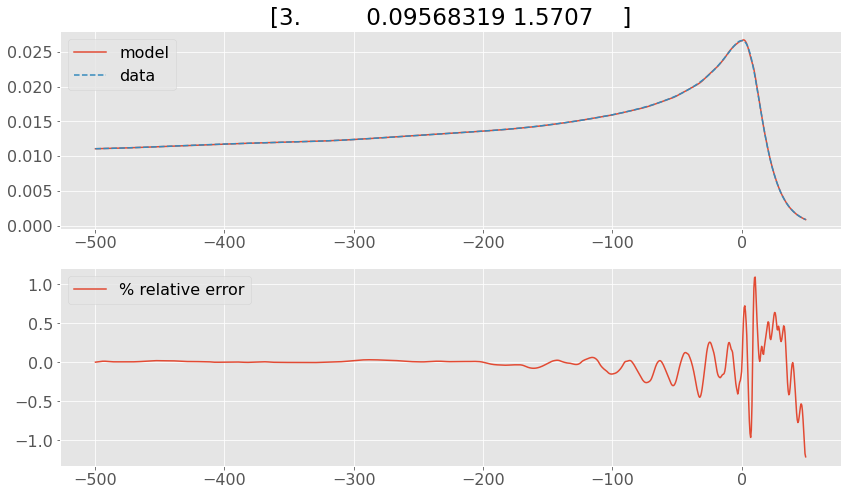

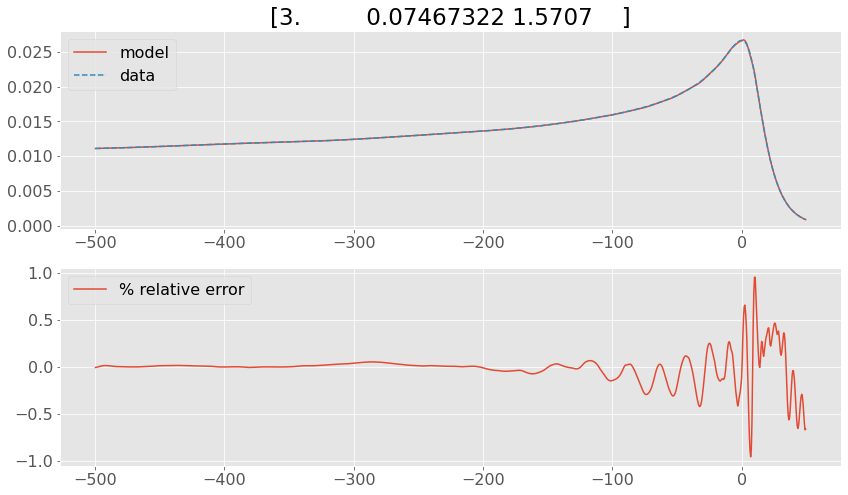

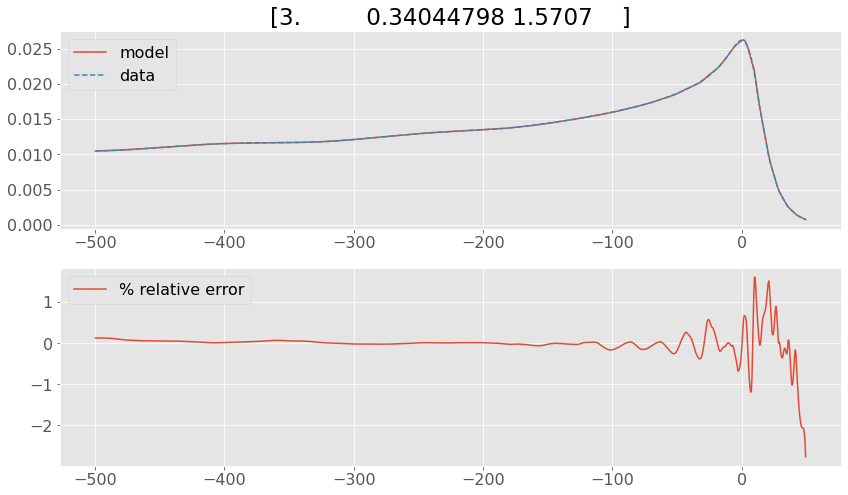

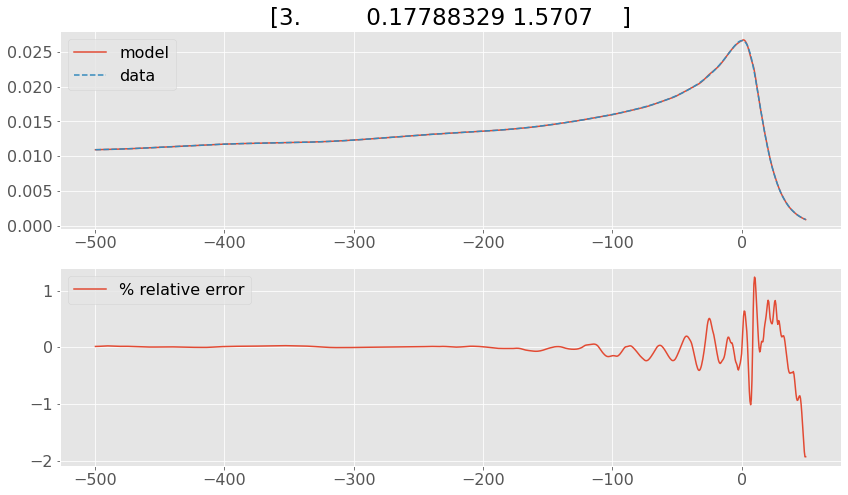

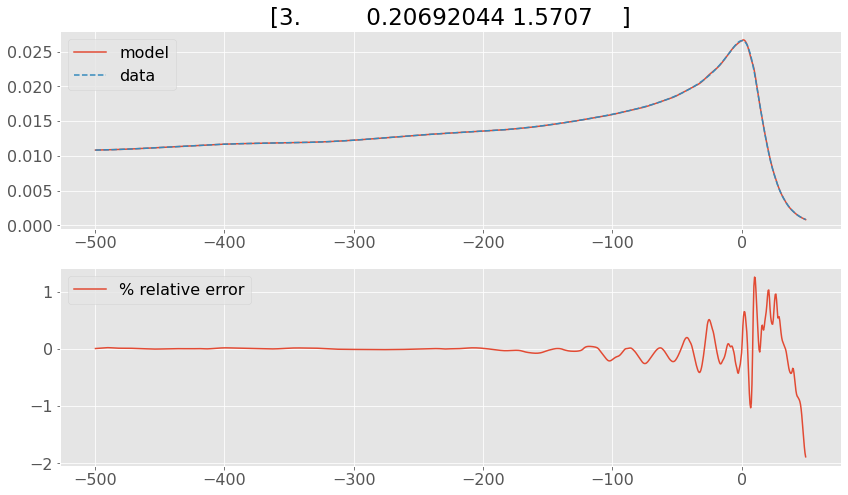

In [187]:
# index = -4

for index in range(coords.shape[1]):

    output = compute_model_input(times_scaled, *coords[:,index])
    output.shape
    yhat = model.predict(output).T
    # yhat = model.predict(X)
    # yhat = model.predict(X[int(1099*1):int(1099*2)])
    yhat.shape
    yhat = compute_preprocessing.apply_pre_process_reverse(yhat, amp_processing_params['mean'], amp_processing_params['max'])
    yhat.shape
    plt.figure(figsize=(14,8))
    plt.subplot(2, 1, 1)
    plt.plot(times, yhat[0], label='model')
    plt.plot(times, amps[index], label='data', ls='--')
#     plt.plot(times, amps_scaled[index], ls='--')
    plt.title(f"{coords[:,index]}")
    # plt.xlim(-100, 50)
    plt.legend()

    plt.subplot(2, 1, 2)
#     plt.plot(times, yhat[0]-amps[index])
    plt.plot(times, 100*(yhat[0]-amps[index])/amps[index], label='% relative error')
#     plt.plot(times, 100*(yhat[0]-amps_scaled[index])/amps_scaled[index], label='% relative error')
    # plt.title(f"{coords[:,index]}")
    plt.legend()
    
    plt.show()
    plt.close()


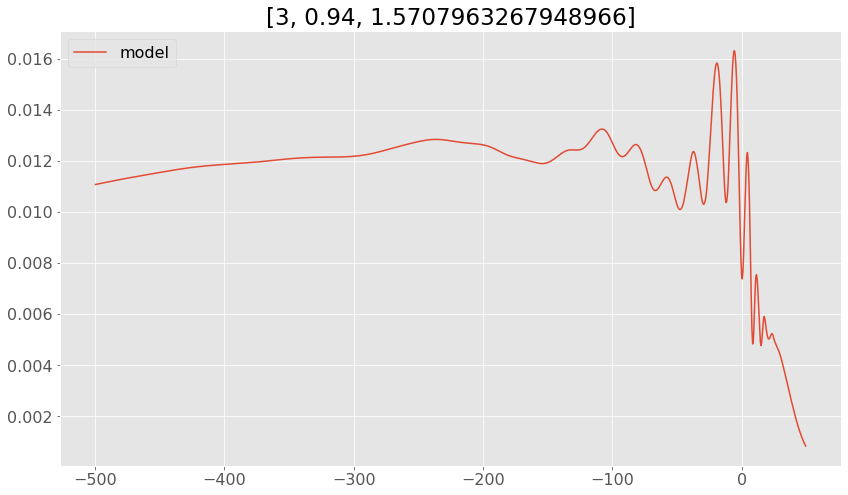

In [194]:
output = compute_model_input(times_scaled, *[3, 0.94, np.pi/2])
output.shape
yhat = model.predict(output).T
# yhat = model.predict(X)
# yhat = model.predict(X[int(1099*1):int(1099*2)])
yhat.shape
yhat = compute_preprocessing.apply_pre_process_reverse(yhat, amp_processing_params['mean'], amp_processing_params['max'])
yhat.shape
plt.figure(figsize=(14,8))
plt.plot(times, yhat[0], label='model')
plt.title(f"{[3, 0.94, np.pi/2]}")
# plt.xlim(-100, 50)
plt.legend()


In [195]:
yhat.shape

(1, 1099)

In [196]:
times.shape

(1099,)

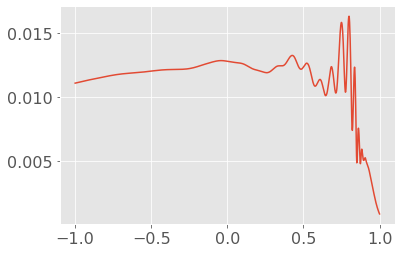

In [197]:
plt.figure()
plt.plot(times_scaled, yhat[0])